In [0]:
# from google.colab import files

# files.upload()

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend

data = pd.read_csv('TXF_data.csv', index_col = 'Time')

data['ma5'] = data.Close.rolling(5).mean()
data['ma10'] = data.Close.rolling(10).mean()
data['ma15'] = data.Close.rolling(15).mean()
data['ma20'] = data.Close.rolling(20).mean()
data['ma40'] = data.Close.rolling(40).mean()
data['ma60'] = data.Close.rolling(60).mean()

_data = data.tail(-60)

start = '2017-09-01'
end = '2018-12-31'
mask = (_data.index > start) & (_data.index <= end)
df_train = _data.loc[mask]

start = '2019-01-01'
end = '2019-07-01'
mask = (_data.index > start) & (_data.index <= end)
df_test = _data.loc[mask]

In [0]:
def buildTrain(df_x, df_y, pastDay = 20):
    list_x, list_y = [], []
    for i in range(df_x.shape[0] - pastDay):
        list_x.append(np.array(df_x.iloc[i:i + pastDay]))
        list_y.append(np.array(df_y.iloc[i + pastDay - 1]))

    return np.array(list_x), np.array(list_y)

def df_to_dataset(dataframe, shuffle = True, batch_size = 32):
    df = dataframe.copy()
    df['Change'] = df.Close.shift(-3) - df.Close
    labels = df.Change.apply(lambda x: 1 if x >= 20 else (2 if x <= -20 else 0))
    df = df.drop(['Change'], axis = 1)
    
    df_norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    
    df_x, df_y = buildTrain(df_norm, labels)
    
    df_y = tf.keras.utils.to_categorical(df_y, 3)
       
    ds = tf.data.Dataset.from_tensor_slices((df_x, df_y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(dataframe))
    ds = ds.batch(batch_size)
    
    return ds, df_x, df_y


batch_size = 200
train_ds, _, _ = df_to_dataset(df_train, batch_size = batch_size)
test_ds, test_x, test_y = df_to_dataset(df_test, shuffle = False, batch_size = batch_size)

train_ds = train_ds.repeat()

In [0]:
AMOUNT = 1
POINT_PRICE = 200
FEES = 200

OpenTime = 'open_time'
OpenPrice = 'open_price'
CloseTime = 'close_time'
ClosePrice = 'close_price'
Volume = 'volume'
Side = 'side'
Profit = 'profit'


class Backtesting(object):
    def __init__(self):
        self.strike = {}
        
        self.last_signal = 'N'
        self.has_pos = False


    def Backtest(self, df, y_pred):
        _df_test = df.reset_index()

        _signal = pd.DataFrame(y_pred, columns = ['Signal']).shift(1)
        
        _df_test = pd.concat([_df_test, _signal], axis = 1).tail(-1)
        
        size = len(_df_test)
        
        self.detail = []
        
        for i in range(size):
            self.Trading(_df_test.iloc[i])
            
        
            
        profit_list = [d[Profit] for d in self.detail]
        profit = sum(profit_list)
            
        return profit
            

    def Trading(self, data):
        _sig = data.Signal
        if not self.has_pos:
            if _sig == 1:
                self.Record_Pos(data, 'buy')
            elif _sig == 2:
                self.Record_Pos(data, 'sell')
        else:
            if _sig == 1 and self.strike[Side] == 'sell':
                self.Record_Detail(data)
                self.Record_Pos(data, 'buy')
            elif _sig == 2 and self.strike[Side] == 'buy':
                self.Record_Detail(data)
                self.Record_Pos(data, 'sell')


    def Record_Pos(self, data, side):       
        self.strike[OpenTime] = data.Time
        self.strike[OpenPrice] = data.Open
        self.strike[Volume] = AMOUNT
        self.strike[Side] = side
        self.has_pos = True
        
        
    def Record_Detail(self, data):
        self.strike[CloseTime] = data.Time
        self.strike[ClosePrice] = data.Open
        
        if self.strike[Side] == 'buy':
            self.strike[Profit] = (self.strike[ClosePrice] - self.strike[OpenPrice]) * POINT_PRICE - FEES
        elif self.strike[Side] == 'sell':
            self.strike[Profit] = (self.strike[OpenPrice] - self.strike[ClosePrice]) * POINT_PRICE - FEES
            
        self.detail.append(self.strike)
        self.strike = {}
        self.has_pos = False
    

    def Save_Detail(self, file_name):
        if len(self.detail) > 0:
            df_detail = pd.DataFrame(self.detail)
            df_detail = df_detail[['open_time', 'open_price', 'volume', 'side', 'close_time', 'close_price', 'profit']]
            df_detail.to_csv(file_name, index = False)
        else:
            print('No history details to save')

In [0]:
GRU_model = keras.Sequential(
[
    layers.GRU(20, input_shape = (20,11,)),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')    
])

In [0]:
backtesting = Backtesting()
LAST_PROFIT = 0

for i in range(10):
    GRU_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    GRU_model.fit(train_ds, epochs = 10, steps_per_epoch = 100)

    pred = GRU_model.predict(test_ds)

    profit = backtesting.Backtest(df_test.tail(-20), backend.eval(tf.argmax(pred, axis = 1)))

    if profit > LAST_PROFIT:
        print('Profit: %f' % (profit))
        model_name = './txf_1hr_gru_%s.h5' % i
        detail_name = './detail_txf_1hr_gru_%s.csv' % i

        GRU_model.save(model_name)
        backtesting.Save_Detail(detail_name)

        LAST_PROFIT = profit
    
    GRU_model.reset_states()

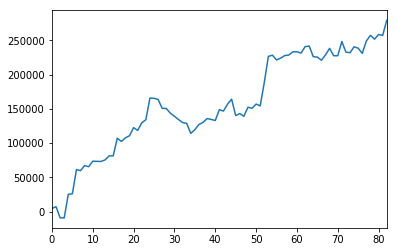

In [8]:
detail = pd.read_csv('detail_txf_1hr_gru_0.csv')

cum_profit = detail['profit'].cumsum()

cum_profit.plot()